In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import json
import pandas as pd

from scipy import interpolate
import base64
import io

# extract right-side window touch line features

In [2]:
window_line_path = "/home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/1_image_mask/window_line.json"

## load window linestrip

In [3]:
with open(window_line_path, mode='r') as jsonfile:
    json_data = json.load(jsonfile)
    
if json_data is None:
    print(f"nothing in {json_data}")
json_data

{'version': '5.5.0',
 'flags': {},
 'shapes': [{'label': 'window_line',
   'points': [[287.1739130434783, 170.43478260869563],
    [320.8695652173913, 181.30434782608694],
    [345.8695652173913, 190.0],
    [379.5652173913044, 205.2173913043478],
    [411.0869565217391, 221.52173913043475],
    [429.5652173913044, 240.0],
    [449.1304347826087, 269.3478260869565],
    [460.0, 295.4347826086956],
    [471.95652173913044, 324.7826086956522],
    [485.0, 368.2608695652173],
    [490.4347826086957, 404.1304347826087],
    [498.04347826086956, 448.69565217391306],
    [500.2173913043478, 496.5217391304348],
    [500.2173913043478, 550.8695652173913],
    [496.95652173913044, 593.2608695652173],
    [487.17391304347825, 638.9130434782608],
    [477.3913043478261, 679.1304347826087],
    [461.0869565217391, 720.4347826086955],
    [441.5217391304348, 763.9130434782608],
    [423.04347826086956, 788.9130434782608],
    [398.04347826086956, 816.086956521739],
    [364.34782608695656, 842.1739

In [4]:
window_linestrips = []

for shape in json_data['shapes']:
    if shape['shape_type'] == 'linestrip':
        window_linestrips.append({
            'label': shape['label'],
            'points': np.array(shape['points']),
        })
               
window_linestrips[0]['points']

array([[287.17391304, 170.43478261],
       [320.86956522, 181.30434783],
       [345.86956522, 190.        ],
       [379.56521739, 205.2173913 ],
       [411.08695652, 221.52173913],
       [429.56521739, 240.        ],
       [449.13043478, 269.34782609],
       [460.        , 295.43478261],
       [471.95652174, 324.7826087 ],
       [485.        , 368.26086957],
       [490.43478261, 404.13043478],
       [498.04347826, 448.69565217],
       [500.2173913 , 496.52173913],
       [500.2173913 , 550.86956522],
       [496.95652174, 593.26086957],
       [487.17391304, 638.91304348],
       [477.39130435, 679.13043478],
       [461.08695652, 720.43478261],
       [441.52173913, 763.91304348],
       [423.04347826, 788.91304348],
       [398.04347826, 816.08695652],
       [364.34782609, 842.17391304],
       [314.34782609, 869.34782609]])

In [5]:
for i, linestrip in enumerate(window_linestrips):
    print(f"{i+1}: {linestrip['label']}, points: {linestrip['points']}")

1: window_line, points: [[287.17391304 170.43478261]
 [320.86956522 181.30434783]
 [345.86956522 190.        ]
 [379.56521739 205.2173913 ]
 [411.08695652 221.52173913]
 [429.56521739 240.        ]
 [449.13043478 269.34782609]
 [460.         295.43478261]
 [471.95652174 324.7826087 ]
 [485.         368.26086957]
 [490.43478261 404.13043478]
 [498.04347826 448.69565217]
 [500.2173913  496.52173913]
 [500.2173913  550.86956522]
 [496.95652174 593.26086957]
 [487.17391304 638.91304348]
 [477.39130435 679.13043478]
 [461.08695652 720.43478261]
 [441.52173913 763.91304348]
 [423.04347826 788.91304348]
 [398.04347826 816.08695652]
 [364.34782609 842.17391304]
 [314.34782609 869.34782609]]


In [6]:
# image information
image_info = {
    'path': json_data['imagePath'],
    'image_data': json_data['imageData'],
    'height': json_data['imageHeight'],
    'width': json_data['imageWidth'],
}

image_info

{'path': '08202025_155419_4.jpg',
 'image_data': '/9j/4AAQSkZJRgABAQAAAQABAAD//gAFQ0g0/9sAQwAIBgYHBgUIBwcHCQkICgwUDQwLCwwZEhMPFB0aHx4dGhwcICQuJyAiLCMcHCg3KSwwMTQ0NB8nOT04MjwuMzQy/9sAQwEJCQkMCwwYDQ0YMiEcITIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIy/8AAEQgEOAeAAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/aAAwDAQACEQMRAD8A8zsNKsptHinki3StG5J3N137V71OdGsAJG8jgeZtG9uxCjv61NomJNJt0OcAKP8AyKx/pVsoFCE8hgv/AI9Ln+lS6ii9Rc1ilLo+mL5hW0O0eZ

## plot window curve

In [7]:
def create_smooth_curve(points, smooth_factor=3):
    """
    Create a smooth interpolated curve from the linestrip points
    """
    if len(points) < 3:
        return points
    
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]
    
    # Create parameter t for parametric interpolation
    t = np.linspace(0, 1, len(points))
    
    # Create smooth curve using cubic spline interpolation
    t_smooth = np.linspace(0, 1, len(points) * smooth_factor)
    
    # Interpolate x and y separately
    spline_x = interpolate.interp1d(t, x, kind='cubic')
    spline_y = interpolate.interp1d(t, y, kind='cubic')
    
    x_smooth = spline_x(t_smooth)
    y_smooth = spline_y(t_smooth)
    
    return np.column_stack((x_smooth, y_smooth))

In [8]:
def decode_image_from_json(image_data_b64):
    """
    Decode base64 image data from labelme JSON
    """
    if image_data_b64:
        # Remove the data URL prefix if present
        if image_data_b64.startswith('data:'):
            image_data_b64 = image_data_b64.split(',')[1]
        
        image_bytes = base64.b64decode(image_data_b64)
        image = Image.open(io.BytesIO(image_bytes))
        return np.array(image)
    return None

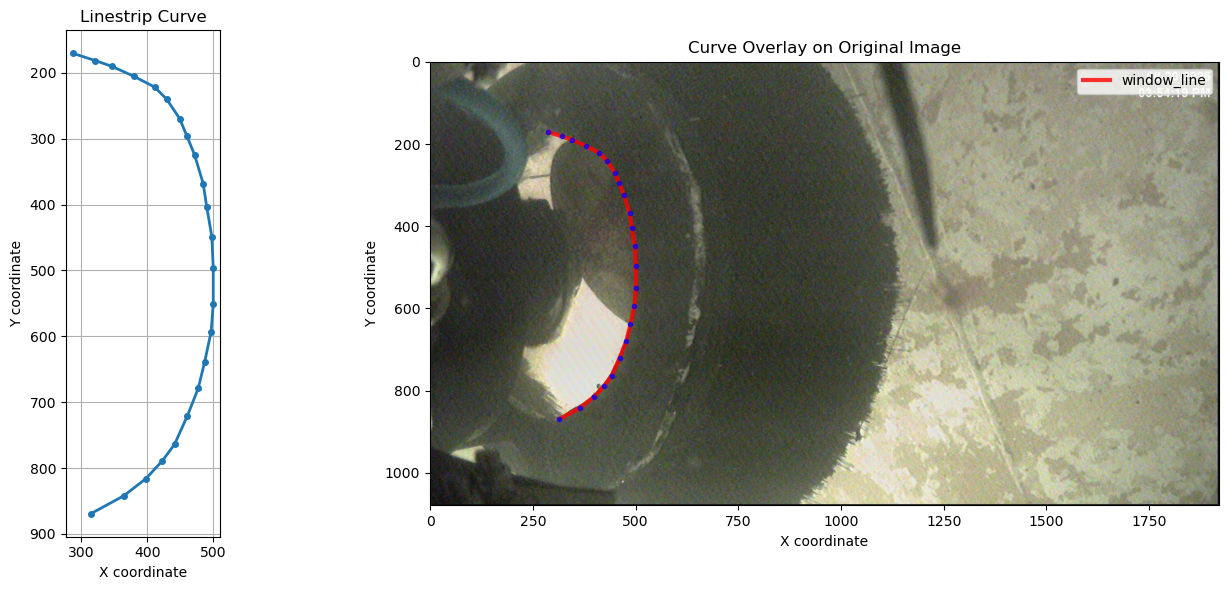

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
# Plot 1: Simple curve plot
ax1 = axes[0]
for linestrip in window_linestrips:
    points = linestrip['points']
    label = linestrip['label']
    
    # Original points connected by lines
    ax1.plot(points[:, 0], points[:, 1], 'o-', 
            linewidth=2, markersize=4, label=f"{label} (original)")
    
ax1.set_title('Linestrip Curve')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
# ax1.legend()
ax1.grid(True) #, alpha=0.3)
ax1.set_aspect('equal')
ax1.invert_yaxis() 


# Plot 2: Overlay on original image
ax2 = axes[1]

# Try to load and display the original image
image = None
if image_info and image_info['image_data']:
    image = decode_image_from_json(image_info['image_data'])

if image is not None:
    ax2.imshow(image)
    ax2.set_title('Curve Overlay on Original Image')
else:
    ax2.set_title('Curve on Image Coordinates')
    ax2.set_xlim(0, image_info['width'] if image_info['width'] > 0 else 2000)
    ax2.set_ylim(image_info['height'] if image_info['height'] > 0 else 1500, 0)

# Plot curves on image
for linestrip in window_linestrips:
    points = linestrip['points']
    label = linestrip['label']
    
    # Original curve
    ax2.plot(points[:, 0], points[:, 1], 'r-', 
            linewidth=3, alpha=0.8, label=f"{label}")
    
    # show points
    ax2.plot(points[:, 0], points[:, 1], 'bo', markersize=3, alpha=0.7)

ax2.legend()
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')

plt.tight_layout()
plt.show()